In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rc
import pickle
import numpy as np
from math import pi
import os

rc("font", **{"family": "serif", "serif": ["Times"]})
rc('text', usetex=True)

SINGLE_WIDTH = 246 / 72
DOUBLE_WIDTH = 510 / 72
GOLDEN_RATIO = (5**0.5 - 1) / 2
DATA_DIR = "../data"
SAVE_FIG = True
SAVE_DIR = "../figs"

Benchmark optimizers

(7, 300) ['LN_BOBYQA' 'LN_COBYLA' 'LN_NELDERMEAD' 'GN_ESCH' 'GN_CRS2_LM'
 'GN_DIRECT_L' 'IMFIL']


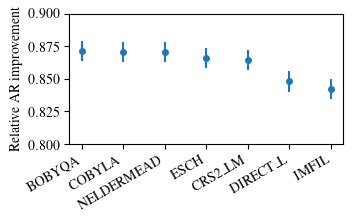

In [2]:
problem = "po"
p = 1
n = 12
seed_pool = list(range(60 if problem == "po" else 100))
reps = 5
fig_size = (SINGLE_WIDTH, SINGLE_WIDTH * GOLDEN_RATIO)

data = pickle.load(
    open(
        f"{DATA_DIR}/{problem}/optimizer/p{p}-s{seed_pool[0]}-{seed_pool[-1]}-r={reps}.pckl",
        "rb",
    ),
)
config = data["config"]
methods = np.concatenate([c["optimizer"] for c in config])
result = data["result"]
data = pickle.load(
    open(
        f"{DATA_DIR}/{problem}/configs/max_ar/LN_COBYLA (NLopt)-p{p}-q{n}-s0-{59 if problem == 'po' else 999}.pckl",
        "rb",
    ),
)
max_ar = data["result"][: len(seed_pool)][None, :, None]
initial_ar = np.array(data["initial_ar"])[: len(seed_pool)][None, :, None]
result = ((result - initial_ar) / (max_ar - initial_ar)).reshape(len(methods), -1)[:-1] # ESCH was run twice
methods = methods[:-1] # ESCH was run twice
order = np.argsort(np.mean(result, axis=1))[:1:-1] # SPSA is too low
result = result[order]
methods = methods[order]

print(result.shape, methods)
plt.figure(figsize=fig_size, layout="constrained")
plt.errorbar(
    range(1, len(methods) + 1),
    np.mean(result, axis=1),
    yerr=np.std(result, axis=1) / np.sqrt(result.shape[1]),
    linestyle="None",
    marker="o",
    markersize=4,
)
plt.ylabel("Relative AR improvement")
plt.xticks(
    range(1, len(methods) + 1),
    [m.split("_", 1)[-1] for m in methods],
    rotation=30,
    ha="right",
)
plt.ylim(0.8, 0.9)
if SAVE_FIG:
    savepath = f"{SAVE_DIR}/{problem}/optimizer/p{p}-s{seed_pool[0]}-{seed_pool[-1]}-r={reps}.pdf"
    os.makedirs(os.path.dirname(savepath), exist_ok=True)
    plt.savefig(savepath)

Initial step size (rhobeg)

{'initial_point': [[1.2310672582, 1.5706881168]], 'maxeval': [4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 100], 'initial_step': [0.01, 0.02, 0.03, 0.04, 0.05, 0.060000000000000005, 0.06999999999999999, 0.08, 0.09, 0.09999999999999999, 0.11, 0.12, 0.13, 0.14, 0.15000000000000002, 0.16, 0.17, 0.18000000000000002, 0.19, 0.2], 'xtol_abs': [1e-10], 'executor_kwargs': [{'shots': None}]}
{'initial_point': [[0.9754194654, 1.7959753912, 2.2202413604, 1.1700312592]], 'maxeval': [6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 100], 'initial_step': [0.01, 0.02526315789473684, 0.04052631578947368, 0.05578947368421053, 0.07105263157894737, 0.0863157894736842, 0.10157894736842105, 0.11684210526315789, 0.13210526315789473, 0.1473684210526316, 0.16263157894736843, 0.17789473684210527, 0.1931578947368421, 0.20842105263157895, 0.2236842105263158, 0.23894736842105263, 0.25421052631578944, 0.2694736842105263, 0.2847368421052632, 0.3], 'xtol_abs': [1e-10], 'executor_kwargs': [{'shots': None}]}
{'initial_

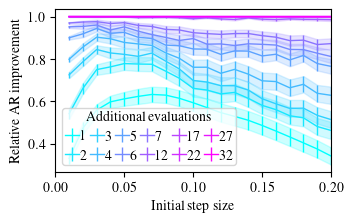

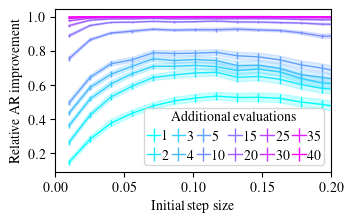

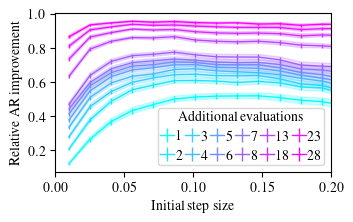

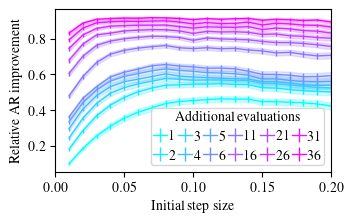

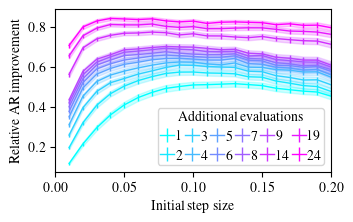

In [3]:
method = "LN_COBYLA (NLopt)"
problem = "maxcut"
n = 12
depth_pool = list(range(1, 6))
seed_pool = list(range(60 if problem == "po" else 100))
fig_size = (SINGLE_WIDTH, SINGLE_WIDTH * GOLDEN_RATIO)

for p in depth_pool:
    data = pickle.load(
        open(
            f"{DATA_DIR}/{problem}/configs/max_ar/{method}-p{p}-q{n}-s0-{59 if problem == 'po' else 999}.pckl",
            "rb",
        ),
    )
    max_ar = data["result"][:len(seed_pool),None,None]


    data = pickle.load(
        open(
            f"{DATA_DIR}/{problem}/configs/rhobeg/{method}-p{p}-q{n}-s{seed_pool[0]}-{seed_pool[-1]}.pckl",
            "rb",
        ),
    )
    config = data["config"]
    maxfev_pool = config["maxeval"][:12]
    rhobeg_pool = config["initial_step"]
    result = data["result"]
    initial_ar = np.array(data["initial_ar"])[:,None,None]

    result = (result - initial_ar) / (max_ar - initial_ar)
    print(config)

    colors = mpl.colormaps["cool"](np.linspace(0, 1, len(maxfev_pool)))
    plt.figure(figsize=fig_size, layout="constrained")
    for j, (maxfev, color) in enumerate(zip(maxfev_pool, colors)):
        ys = result[:, j]
        y = np.mean(ys, axis=0)
        std_err = np.std(ys, axis=0) / np.sqrt(len(seed_pool))
        plt.errorbar(
            rhobeg_pool,
            y,
            yerr=std_err,
            label=f"{maxfev - 2 * p - 1}",
            color=color,
            linewidth=1,
        )
        plt.fill_between(rhobeg_pool, y - std_err, y + std_err, alpha=0.2, color=color)

    # plt.ylim((0, 1.05))
    if problem == "maxcut":
        plt.xlim((0, 0.2))
    elif problem == "po":
        plt.xlim((0, 1))
    plt.ylabel("Relative AR improvement")
    plt.xlabel("Initial step size")
    plt.legend(
        title="Additional evaluations",
        ncol=6,
        columnspacing=0.2,
        handletextpad=0.1,
        handlelength=1,
        borderpad=0.2,
        markerscale=0.1,
    )
    # plt.tight_layout()
    if SAVE_FIG:
        savepath = f"{SAVE_DIR}/{problem}/rhobeg/{method}-p{p}-q{n}.pdf"
        os.makedirs(os.path.dirname(savepath), exist_ok=True)
        plt.savefig(savepath)

Budget allocation

{'initial_point': [[1.2310672582, 1.5706881168]], 'maxeval': [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 25, 30, 35, 40, 45, 50], 'initial_step': [0.1], 'ftol_rel': [1e-13], 'executor_kwargs': [{'shots': 2500}, {'shots': 2000}, {'shots': 1666}, {'shots': 1428}, {'shots': 1250}, {'shots': 1111}, {'shots': 1000}, {'shots': 909}, {'shots': 833}, {'shots': 769}, {'shots': 714}, {'shots': 666}, {'shots': 625}, {'shots': 588}, {'shots': 555}, {'shots': 526}, {'shots': 500}, {'shots': 400}, {'shots': 333}, {'shots': 285}, {'shots': 250}, {'shots': 222}, {'shots': 200}]}
{'initial_point': [[0.9754194654, 1.7959753912, 2.2202413604, 1.1700312592]], 'maxeval': [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 25, 30, 35, 40, 45, 50], 'initial_step': [0.1], 'ftol_rel': [1e-13], 'executor_kwargs': [{'shots': 1666}, {'shots': 1428}, {'shots': 1250}, {'shots': 1111}, {'shots': 1000}, {'shots': 909}, {'shots': 833}, {'shots': 769}, {'shots': 714}, {'shots': 666}, {'shots': 6

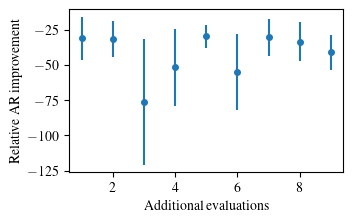

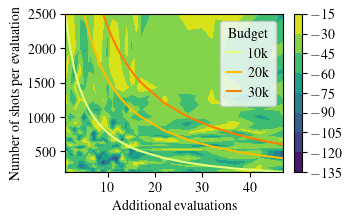

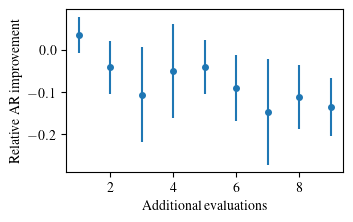

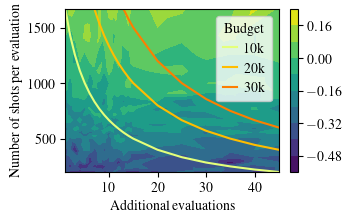

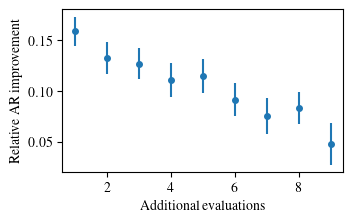

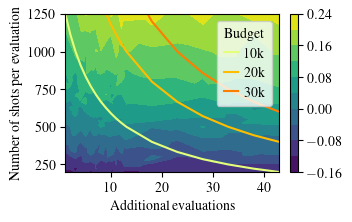

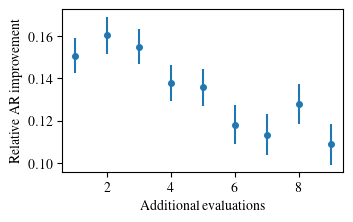

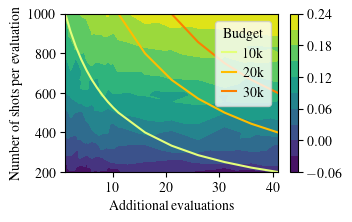

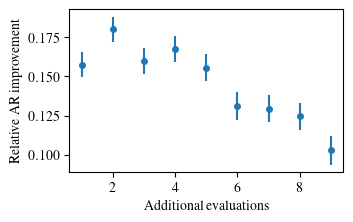

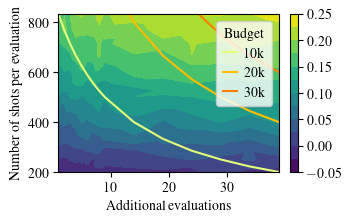

In [4]:
method = "LN_COBYLA (NLopt)"
problem = "maxcut"
n = 12
depth_pool = list(range(1, 6))
seed_pool = list(range(60 if problem == "po" else 1000))
fig_size = (SINGLE_WIDTH, SINGLE_WIDTH * GOLDEN_RATIO)


for p in depth_pool:
    data = pickle.load(
        open(
            f"{DATA_DIR}/{problem}/configs/max_ar/LN_COBYLA (NLopt)-p{p}-q{n}-s0-{59 if problem == 'po' else 999}.pckl",
            "rb",
        ),
    )
    max_ar = data["result"][: len(seed_pool), None, None]

    data = pickle.load(
        open(
            f"{DATA_DIR}/{problem}/configs/budget/{method}-p{p}-q{n}-s{seed_pool[0]}-{seed_pool[-1]}.pckl",
            "rb",
        ),
    )
    config = data["config"]
    result = data["result"][:, :, :]
    initial_ar = np.array(data["initial_ar"])[:, None, None]

    print(config)
    shots_pool = [d["shots"] for d in config["executor_kwargs"]][:]
    maxfev_pool = config["maxeval"][:]
    maxfev_pool = np.array(maxfev_pool) - 2 * p - 1
    result = (result - initial_ar) / (max_ar - initial_ar)

    plt.figure(figsize=fig_size, layout="constrained")
    plt.errorbar(
        maxfev_pool[:9],
        [np.mean(result, axis=0)[i, i] for i in range(len(shots_pool))][:9],
        yerr=[
            np.std(result[:, i, i]) / np.sqrt(result.shape[0])
            for i in range(len(shots_pool))
        ][:9],
        fmt="o",
        # capsize=2,
        markersize=4,
    )
    plt.ylabel("Relative AR improvement")
    plt.xlabel("Additional evaluations")
    if SAVE_FIG:
        savepath = f"{SAVE_DIR}/{problem}/budget/{method}-p{p}-q{n}-slice.pdf"
        os.makedirs(os.path.dirname(savepath), exist_ok=True)
        plt.savefig(savepath)

    budget = 10000

    plt.figure(figsize=fig_size, layout="constrained")
    x, y = np.meshgrid(maxfev_pool, shots_pool, indexing="ij")
    z = np.mean(result, axis=0)
    fig = plt.tricontourf(x.flat, y.flat, z.flat, levels=10)
    colors = mpl.colormaps["Wistia"](np.linspace(0, 1, 3))
    for i in range(1, 4):
        plt.plot(
            maxfev_pool,
            budget * i // (maxfev_pool + 2 * p + 1),
            label=f"{i}0k",
            color=colors[i - 1],
        )
    plt.colorbar(fig)
    plt.ylim((shots_pool[-1], shots_pool[0]))
    plt.xlabel("Additional evaluations")
    plt.ylabel("Number of shots per evaluation")
    plt.legend(
        title="Budget",
        handletextpad=0.5,
        handlelength=1,
        borderpad=0.5,
        loc="upper right",
    )
    if SAVE_FIG:
        savepath = f"{SAVE_DIR}/{problem}/budget/{method}-p{p}-q{n}.pdf"
        os.makedirs(os.path.dirname(savepath), exist_ok=True)
        plt.savefig(savepath)

Landscapes

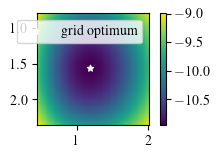

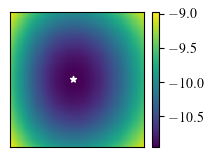

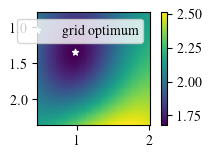

/Users/ruslan/soft/anaconda3/envs/shot_frugal/lib/python3.11/site-packages/oscar/landscape/landscape.py:69: UserWarning: Interpolator not found. Attempting to initialize the interpolator with default configurations...
  warnings.warn(


Total evaluation time: 0.011589765548706055
Optimal parameters reported: [1.17524596 1.41799973]
Optimal value reported: -11.075579458925068
Number of evaluations: 20


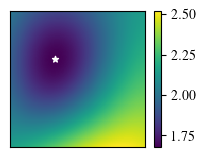

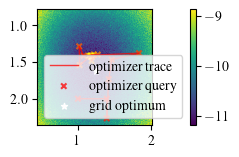

Total evaluation time: 0.012212276458740234
Optimal parameters reported: [1.20646159 1.66783789]
Optimal value reported: -10.95778699383693
Number of evaluations: 20


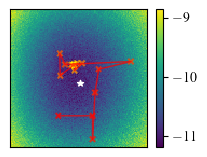

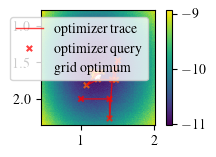

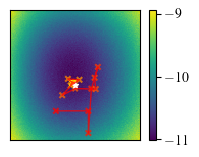

In [6]:
from functools import partial
from oscar import plot_2d_landscape, CustomExecutor, Landscape

problem = "maxcut"
p = 1
n = 12
seed = 0
resolutions = [256, 128]
gamma_shift = pi / 2
beta_shift = -pi / 4
rng = np.random.default_rng(seed)


def shotted_measurement(params, landscape, landscape_std, sense, shots=None):
    energy = landscape.interpolator(np.asarray(params)).item()
    if shots is None:
        return sense * energy
    energy_std = landscape_std.interpolator(np.asarray(params)).item() / np.sqrt(shots)
    return sense * rng.normal(energy, energy_std)


landscapes = []
filename = f"{DATA_DIR}/{problem}/landscapes/{p=}/{n=}/{problem}-{p=}-{n=}-{seed=}-({2*gamma_shift:.2f}, {2*beta_shift:.2f})-{resolutions}"
for objective in ["expectation", "std"]:
    landscapes.append(
        np.load(filename + f"-{objective}.pckl", allow_pickle=True)[64:192]
    )
    figure = plot_2d_landscape(
        landscapes[-1],
        figure=plt.figure(
            figsize=(DOUBLE_WIDTH / 3, DOUBLE_WIDTH / 3 * GOLDEN_RATIO),
            layout="constrained",
        ),
    )
    plt.figure(figure)
    plt.xticks([], [])
    plt.yticks([], [])
    plt.legend().remove()
    if SAVE_FIG:
        savepath = filename.replace(DATA_DIR, SAVE_DIR) + f"-{objective}.pdf"
        os.makedirs(os.path.dirname(savepath), exist_ok=True)
        plt.savefig(savepath)

for shots in [500, 5000]:
    eval_func = partial(
        shotted_measurement,
        landscape=landscapes[0],
        landscape_std=landscapes[-1],
        sense=1,
        shots=shots,
    )
    from oscar import NLoptOptimizer, QiskitOptimizer

    landscape = Landscape.like(landscapes[0])
    landscape.run_all(CustomExecutor(eval_func))
    trace, original_result = NLoptOptimizer(
        "LN_COBYLA", xtol_abs=1e-11, maxeval=20
    ).run(
        CustomExecutor(eval_func),
        initial_point=[1.0, 2.0],
        bounds=[landscape.param_bounds[0], landscape.param_bounds[1][::-1]],
    )
    trace.print_result()
    figure = plot_2d_landscape(
        landscape,
        trace=trace,
        figure=plt.figure(
            figsize=(DOUBLE_WIDTH / 3, DOUBLE_WIDTH / 3 * GOLDEN_RATIO),
            layout="constrained",
        ),
    )
    plt.figure(figure)
    plt.xticks([], [])
    plt.yticks([], [])
    plt.legend(
        loc="upper center", labelspacing=0.1, borderpad=0.1, bbox_to_anchor=(0.5, 1.05)
    ).remove()
    if SAVE_FIG:
        savepath = filename.replace(DATA_DIR, SAVE_DIR) + f"-{shots=}.pdf"
        os.makedirs(os.path.dirname(savepath), exist_ok=True)
        plt.savefig(savepath)